## Import libraries and relavant functions

In [95]:
import sys, os
sys.stderr = open(os.devnull, 'w')

import torch
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import json

from pendulum_ml.models.registry import make_model
from pendulum_ml.data.dataset import build_loaders
from pendulum_ml.verification.attacks import make_attack_fn
from pendulum_ml.verification import xai

run_clean = "quad_clean_config"
run_adv = "quad_adv_config"
# run_adv="trial_quad_config_0.2_100"
base_path = Path("../experiments")
model_path= Path("../models/checkpoints")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


## Load our pretrained model on OG dataset and further on a mix of adversarial+clean dataset (p=0.5)

In [96]:
def load_model(run_id):
    run_dir = base_path / run_id
    cfg = json.loads((run_dir / "config.json").read_text())
    model = make_model(cfg["model"]["name"],
                       in_dim=cfg["model"]["in_dim"],
                       hidden=tuple(cfg["model"]["hidden"]),
                       out_dim=cfg["model"]["out_dim"]).to(device)
    ckpt = model_path / f"{run_id}.pt"
    model.load_state_dict(torch.load(ckpt, map_location=device))
    model.eval()
    return model, cfg

model_clean, cfg_clean = load_model(run_clean)
model_adv, cfg_adv = load_model(run_adv)
print(cfg_clean)


{'seed': 42, 'device': 'cpu', 'system': 'quadcopter', 'dynamics': {'dt': 0.01, 'control_dt': 0.01, 'integrator': 'rk4', 'params': {'quad': {'mass': 1.5, 'inertia': 0.03, 'arm_length': 0.25}, 'payload': {'mass': 0.25, 'rope_length': 1.0}, 'environment': {'gravity': 9.81}, 'winch': {'model': 'algebraic', 'omega': 10.0}, 'actuators': {'max_thrust': 20.0, 'max_pitch_torque': 5.0, 'min_pitch_torque': -5.0}}}, 'controller': {'type': 'pid', 'pid': {'x': {'Kp': 8, 'Ki': 0, 'Kd': 12, 'u_min': -10.0, 'u_max': 10.0}, 'z': {'Kp': 40.0, 'Ki': 5, 'Kd': 10, 'u_min': -10.0, 'u_max': 10.0, 'setpoint': 0.0}, 'theta': {'Kp': 30, 'Ki': 0, 'Kd': 4, 'u_min': -5.0, 'u_max': 5.0}, 'phi': {'Kp': 30.0, 'Ki': 0, 'Kd': 4.0, 'u_min': -10.0, 'u_max': 10.0}, 'l': {'Kp': 0.0, 'Ki': 0.0, 'Kd': 0.0, 'u_min': 0.0, 'u_max': 0.0}}}, 'data': {'n_trajectories': 1, 'initial_state': [[-0.0, 5.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]], 'sim_time': 20, 'train_ratio': 0.8, 'val_ratio': 0.1, 'test_ratio': 0.1, 'standardize': Tr

## Load attack function to generate model-aware PGD attack on test set

In [50]:
attack_fn = make_attack_fn(method="pgd", eps=0.1, steps=40, alpha=0.0025)
loaders = build_loaders(cfg_clean)
X_test, Y_test = next(iter(loaders["test"]))
X_test, Y_test = X_test.to(device), Y_test.to(device)

x = X_test[0:1]
y = Y_test[0:1]

x_adv = attack_fn(model_clean, x, y)

with torch.no_grad():
    clean_pred = model_clean(x)
    adv_pred = model_clean(x_adv)
    robust_pred = model_adv(x_adv)

print("Clean model (clean input):", clean_pred)
print("Clean model (adv input):", adv_pred)
print("Adv-trained model (adv input):", robust_pred)


Clean model (clean input): tensor([[-2.0983e-02,  1.6094e+00, -1.5982e-02,  2.8992e-02, -2.6324e-04]])
Clean model (adv input): tensor([[-0.1048,  1.8413, -0.0368,  0.0929,  0.0093]])
Adv-trained model (adv input): tensor([[ 0.0202,  1.6568, -0.0627,  0.0080,  0.0069]])


## Diagram of how features look under attack

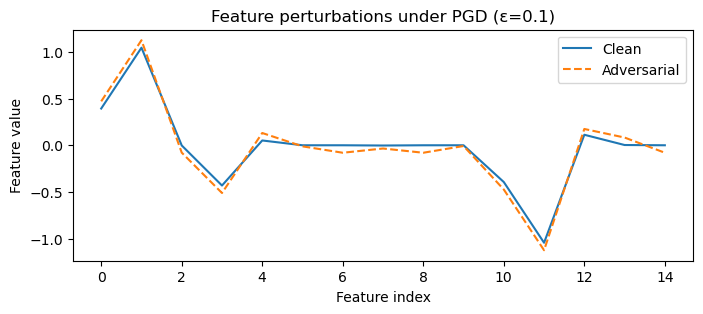

In [70]:
attack_fn = make_attack_fn(method="pgd", eps=0.08, steps=40)

x = X_test[0:1]
y = Y_test[0:1]
x_adv = attack_fn(model_clean, x, y)

plt.figure(figsize=(8,3))
plt.plot(x.cpu().numpy().flatten(), label="Clean")
plt.plot(x_adv.cpu().numpy().flatten(), "--", label="Adversarial")
plt.title("Feature perturbations under PGD (ε=0.1)")
plt.xlabel("Feature index")
plt.ylabel("Feature value")
plt.legend()
plt.show()


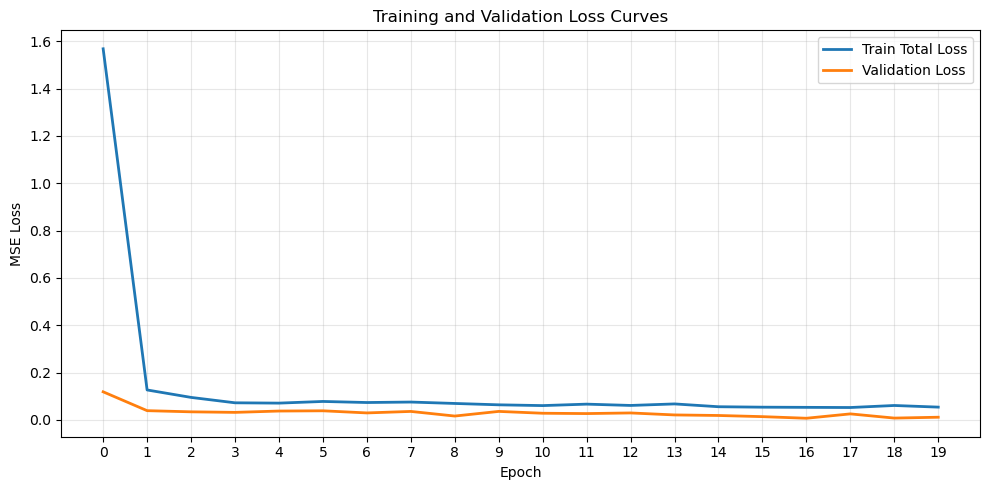

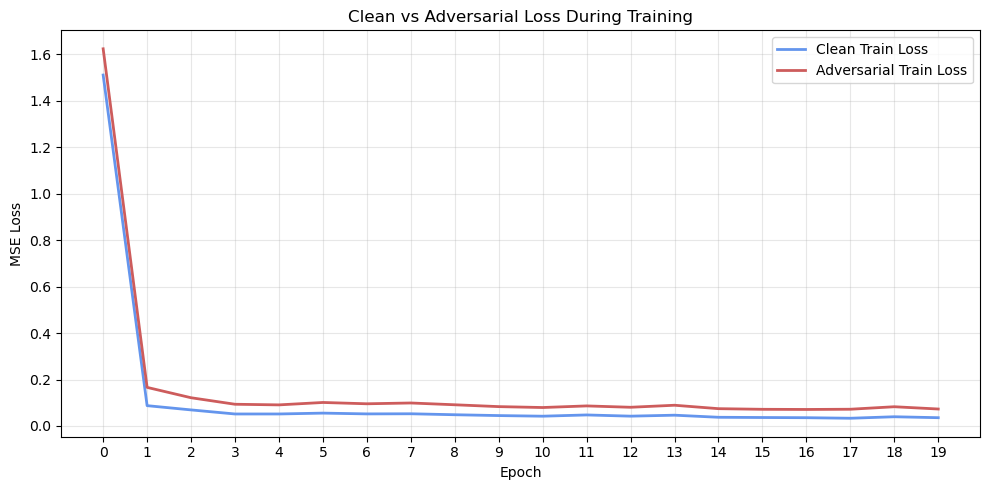

In [ ]:
import pandas as pd

# Load metrics file
metrics_path = Path("../experiments/trial_quad_config_0.2_100/metrics.csv")  
# metrics_path = Path("../experiments/quad_adv_config/metrics.csv")  
df = pd.read_csv(metrics_path)
df = df[df["epoch"].apply(lambda x: str(x).isdigit())]  # drop 'final' row

# --- Basic losses ---
plt.figure(figsize=(10,5))
plt.plot(df["epoch"], df["train_loss"], label="Train Total Loss", linewidth=2)
plt.plot(df["epoch"], df["val_loss"], label="Validation Loss", linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training and Validation Loss Curves")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# --- Clean vs Adversarial training loss ---
plt.figure(figsize=(10,5))
plt.plot(df["epoch"], df["train_clean_loss"], label="Clean Train Loss", color="cornflowerblue", linewidth=2)
plt.plot(df["epoch"], df["train_adv_loss"], label="Adversarial Train Loss", color="indianred", linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Clean vs Adversarial Loss During Training")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()



In [55]:
def evaluate(model, X, Y, attack_fn):
    with torch.no_grad():
        clean_loss = torch.nn.functional.mse_loss(model(X), Y).item()
    X_adv = attack_fn(model, X, Y)
    with torch.no_grad():
        adv_loss = torch.nn.functional.mse_loss(model(X_adv), Y).item()
    return clean_loss, adv_loss

epsilons = [0.01, 0.05, 0.08, 0.1, 0.2]
steps = [5, 10, 20, 40, 50]
results = []

for eps in epsilons:
    for s in steps:
        attack = make_attack_fn("pgd", eps=eps, steps=s, alpha=eps/s)
        loss_clean, loss_adv_clean = evaluate(model_clean, X_test, Y_test, attack)
        loss_clean_adv, loss_adv_adv = evaluate(model_adv, X_test, Y_test, attack)
        results.append((eps, s, loss_clean, loss_adv_clean, loss_clean_adv, loss_adv_adv))

import pandas as pd
df = pd.DataFrame(results, columns=["eps", "steps", "clean_loss", "adv_loss_clean", "clean_loss_adv","adv_loss_adv"])
df


eps  steps  clean_loss  adv_loss_clean  clean_loss_adv  adv_loss_adv
0   0.01      5    0.003986        0.005281        0.002142      0.002795
1   0.01     10    0.003986        0.005156        0.002142      0.002722
2   0.01     20    0.003986        0.005182        0.002142      0.002762
3   0.01     40    0.003986        0.005142        0.002142      0.002725
4   0.01     50    0.003986        0.005056        0.002142      0.002710
5   0.05      5    0.003986        0.014632        0.002142      0.006464
6   0.05     10    0.003986        0.014179        0.002142      0.006247
7   0.05     20    0.003986        0.014222        0.002142      0.006900
8   0.05     40    0.003986        0.014392        0.002142      0.006422
9   0.05     50    0.003986        0.013848        0.002142      0.006070
10  0.08      5    0.003986        0.026246        0.002142      0.011557
11  0.08     10    0.003986        0.027618        0.002142      0.011526
12  0.08     20    0.003986        0.028182        0.002142      0.010119
13  0.08     40    0.003986        0.026024        0.002142      0.011401
14  0.08     50    0.003986        0.026365        0.002142      0.011759
15  0.10      5    0.003986        0.041239        0.002142      0.016310
16  0.10     10    0.003986        0.035415        0.002142      0.016530
17  0.10     20    0.003986        0.036528        0.002142      0.017339
18  0.10     40    0.003986        0.039295        0.002142      0.017060
19  0.10     50    0.003986        0.035776        0.002142      0.018077
20  0.20      5    0.003986        0.125201        0.002142      0.049181
21  0.20     10    0.003986        0.119731        0.002142      0.055769
22  0.20     20    0.003986        0.130021        0.002142      0.053395
23  0.20     40    0.003986        0.131136        0.002142      0.056601
24  0.20     50    0.003986        0.129765        0.002142      0.058701

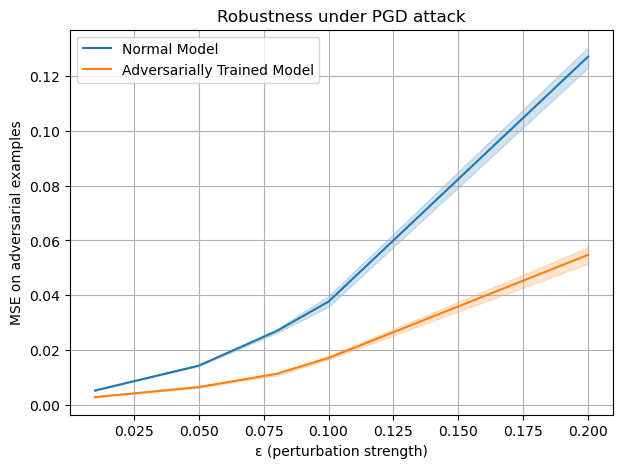

In [56]:
import seaborn as sns
plt.figure(figsize=(7,5))
sns.lineplot(data=df, x="eps", y="adv_loss_clean", label="Normal Model")
sns.lineplot(data=df, x="eps", y="adv_loss_adv", label="Adversarially Trained Model")
plt.title("Robustness under PGD attack")
plt.xlabel("ε (perturbation strength)")
plt.ylabel("MSE on adversarial examples")
plt.legend()
plt.grid(True)
plt.show()


## **LIME — Local Interpretable Model-agnostic Explanations**

> **Core Question:**  
> *If I perturb feature _i_ slightly near this sample, how much does the model’s prediction change locally?*

---

### **1. Drift Analysis (Stability Under Attack)**

- When we apply an **adversarial perturbation**, we re-compute the LIME explanations.  
- The **LIME Drift** measures how much those feature importance weights change:  

  \[
  \text{Drift} = \sum_i | w_i^{(\text{clean})} - w_i^{(\text{adv})} |
  \]

- A **lower drift** ⇒ the model’s reasoning stays consistent under perturbation → **more robust & explainable**.  
- A **higher drift** ⇒ explanations fluctuate easily → **less stable model** (susceptible to adversarial shifts).

---

### **Conclusions**

- Our *adversarially trained model* exhibits **lower mean LIME drift**, indicating **more consistent decision logic** even when inputs are attacked.

---

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


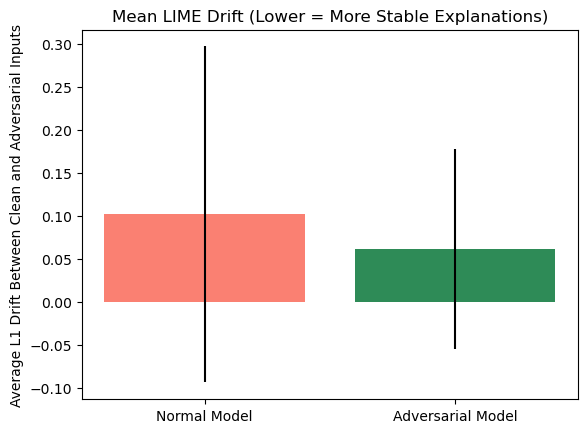

LIME Drift — Normal: 0.1019 ± 0.1953 | Adversarial: 0.0615 ± 0.1161


In [57]:


feature_names = cfg_clean["features"][:15]

# Collect LIME drifts for multiple test samples
explainer = xai.explain_lime(model_clean, X_test[:100].detach().cpu(), feature_names)
explainer_adv = xai.explain_lime(model_adv, X_test[:100].detach().cpu(), feature_names)

def avg_drift(model, explainer, X, attack_fn, n_samples=30):
    drifts = []
    for i in np.random.choice(len(X), n_samples, replace=False):
        x = X[i:i+1]
        y = model(x)
        x_adv = attack_fn(model, x, y)
        exp_clean = xai.lime_explain_instance(model, explainer, x[0], output_idx=0)
        exp_adv = xai.lime_explain_instance(model, explainer, x_adv[0], output_idx=0)
        drifts.append(xai.attribution_drift(exp_clean, exp_adv))
    return np.mean(drifts), np.std(drifts)

mean_clean, std_clean = avg_drift(model_clean, explainer, X_test, make_attack_fn("pgd", eps=0.1, steps=40))
mean_adv, std_adv = avg_drift(model_adv, explainer_adv, X_test, make_attack_fn("pgd", eps=0.1, steps=40))

plt.bar(["Normal Model", "Adversarial Model"], [mean_clean, mean_adv], yerr=[std_clean, std_adv], color=["salmon","seagreen"])
plt.title("Mean LIME Drift (Lower = More Stable Explanations)")
plt.ylabel("Average L1 Drift Between Clean and Adversarial Inputs")
plt.show()

print(f"LIME Drift — Normal: {mean_clean:.4f} ± {std_clean:.4f} | Adversarial: {mean_adv:.4f} ± {std_adv:.4f}")



---

### **2. Local Explanations**

- **Goal:** Understand which input features (state variables) most influence the model’s output *in the neighborhood* of a specific data point.  

- We visualize weights, showing which features dominate each predicted control variable.

---


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


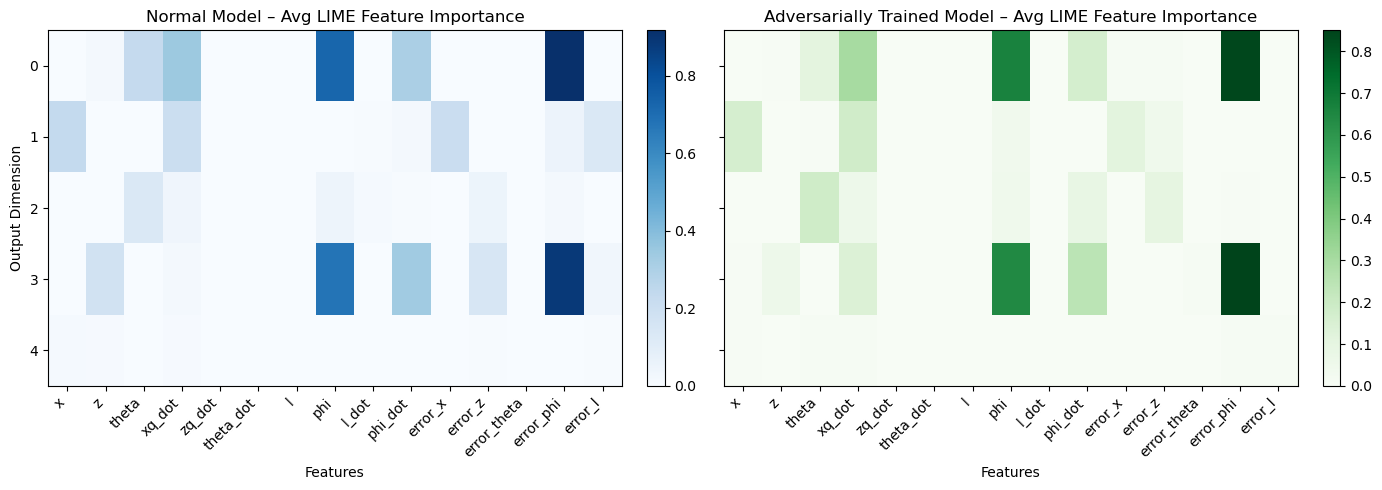

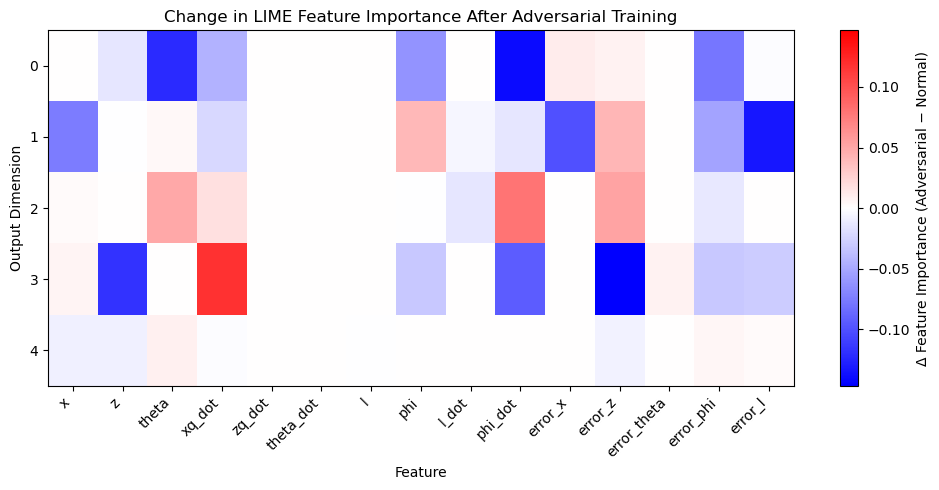

In [71]:


out_dim = model_clean(torch.zeros(1, len(feature_names)).to(device)).shape[1]
n_samples = 32  # number of random test samples for averaging

# Create LIME explainers
explainer_clean = xai.explain_lime(model_clean, X_test[:100].detach().cpu(), feature_names)
explainer_adv   = xai.explain_lime(model_adv,   X_test[:100].detach().cpu(), feature_names)

# Initialize accumulators
avg_importance_clean = np.zeros((out_dim, len(feature_names)))
avg_importance_adv   = np.zeros((out_dim, len(feature_names)))

# Randomly sample test points
idxs = np.random.choice(len(X_test), n_samples, replace=False)

for i in idxs:
    x = X_test[i:i+1]
    with torch.no_grad():
        y = model_clean(x)
    for j in range(out_dim):
        exp_clean = xai.lime_explain_instance(model_clean, explainer_clean, x[0], output_idx=j)
        exp_adv   = xai.lime_explain_instance(model_adv, explainer_adv, x[0], output_idx=j)

        dict_clean = dict(exp_clean)
        dict_adv   = dict(exp_adv)

        for k, f in enumerate(feature_names):
            avg_importance_clean[j, k] += abs(dict_clean.get(f, 0.0))
            avg_importance_adv[j, k]   += abs(dict_adv.get(f, 0.0))

# Normalize by sample count
avg_importance_clean /= n_samples
avg_importance_adv   /= n_samples

# Compute difference
diff = avg_importance_adv - avg_importance_clean

# --- Plot 1: Normal Model ---
fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

im0 = axs[0].imshow(avg_importance_clean, cmap="Blues", aspect="auto")
axs[0].set_title("Normal Model – Avg LIME Feature Importance")
axs[0].set_xlabel("Features")
axs[0].set_ylabel("Output Dimension")
axs[0].set_xticks(np.arange(len(feature_names)))
axs[0].set_xticklabels(feature_names, rotation=45, ha="right")
fig.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04)

# --- Plot 2: Adversarial Model ---
im1 = axs[1].imshow(avg_importance_adv, cmap="Greens", aspect="auto")
axs[1].set_title("Adversarially Trained Model – Avg LIME Feature Importance")
axs[1].set_xlabel("Features")
axs[1].set_xticks(np.arange(len(feature_names)))
axs[1].set_xticklabels(feature_names, rotation=45, ha="right")
fig.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

# --- Plot 3: Difference Map (Adv - Normal) ---
plt.figure(figsize=(10,5))
plt.imshow(diff, cmap="bwr", aspect="auto", vmin=-np.max(abs(diff)), vmax=np.max(abs(diff)))
plt.colorbar(label="Δ Feature Importance (Adversarial − Normal)")
plt.title("Change in LIME Feature Importance After Adversarial Training")
plt.xlabel("Feature")
plt.ylabel("Output Dimension")
plt.xticks(np.arange(len(feature_names)), feature_names, rotation=45, ha="right")
plt.tight_layout()
plt.show()


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


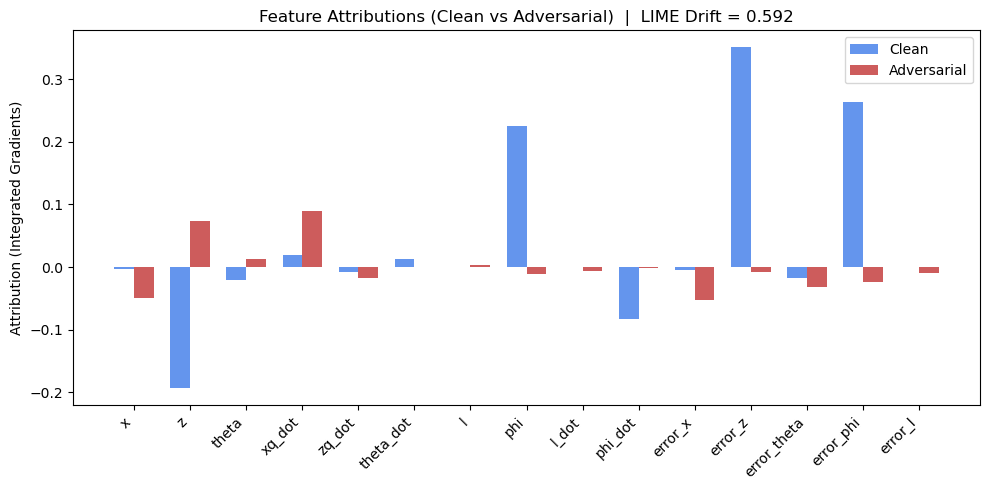

In [99]:

# --- LIME drift computation ---
explainer = xai.explain_lime(model_clean, X_test[:100].detach().cpu(), feature_names)
exp_clean = xai.lime_explain_instance(model_clean, explainer, x[0], output_idx=0)
exp_adv   = xai.lime_explain_instance(model_clean, explainer, x_adv[0], output_idx=0)
drift = xai.attribution_drift(exp_clean, exp_adv)
print(f"LIME Drift: {drift:.4f}")

# --- Integrated Gradients for both clean & adv ---
attrs_clean, _ = xai.integrated_gradients(model_clean, x, target=0)
attrs_adv, _   = xai.integrated_gradients(model_clean, x_adv, target=0)

vals_clean = attrs_clean.cpu().numpy().flatten()
vals_adv   = attrs_adv.cpu().numpy().flatten()

# --- Combined bar chart ---
x_idx = np.arange(len(feature_names))
width = 0.35

plt.figure(figsize=(10,5))
plt.bar(x_idx - width/2, vals_clean, width, label="Clean", color="cornflowerblue")
plt.bar(x_idx + width/2, vals_adv,   width, label="Adversarial", color="indianred")

plt.xticks(x_idx, feature_names, rotation=45, ha="right")
plt.ylabel("Attribution (Integrated Gradients)")
plt.title(f"Feature Attributions (Clean vs Adversarial)  |  LIME Drift = {drift:.3f}")
plt.legend()
plt.tight_layout()
plt.show()


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


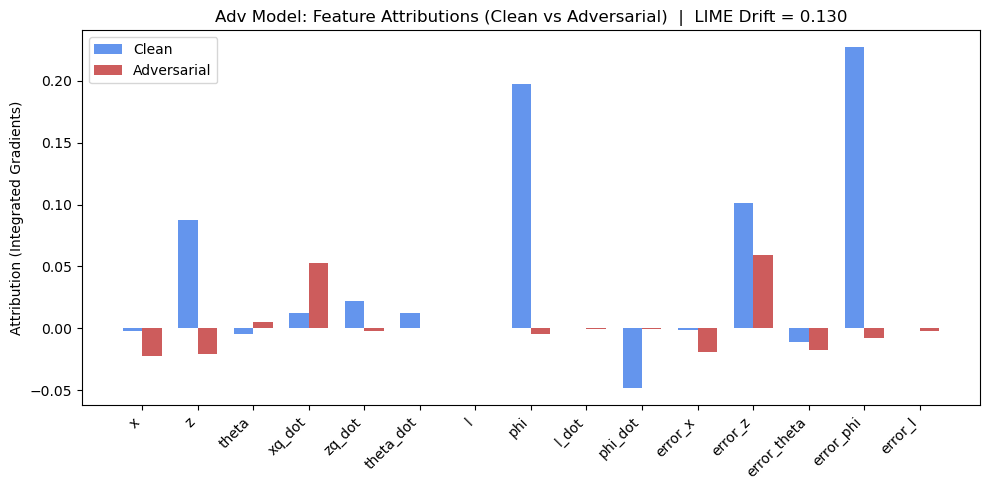

In [100]:
# --- LIME drift computation ---
explainer = xai.explain_lime(model_adv, X_test[:100].detach().cpu(), feature_names)
exp_clean = xai.lime_explain_instance(model_adv, explainer, x[0], output_idx=0)
exp_adv   = xai.lime_explain_instance(model_adv, explainer, x_adv[0], output_idx=0)
drift = xai.attribution_drift(exp_clean, exp_adv)
print(f"LIME Drift: {drift:.4f}")

# --- Integrated Gradients for both clean & adv ---
attrs_clean, _ = xai.integrated_gradients(model_adv, x, target=0)
attrs_adv, _   = xai.integrated_gradients(model_adv, x_adv, target=0)

vals_clean = attrs_clean.cpu().numpy().flatten()
vals_adv   = attrs_adv.cpu().numpy().flatten()

# --- Combined bar chart ---
x_idx = np.arange(len(feature_names))
width = 0.35

plt.figure(figsize=(10,5))
plt.bar(x_idx - width/2, vals_clean, width, label="Clean", color="cornflowerblue")
plt.bar(x_idx + width/2, vals_adv,   width, label="Adversarial", color="indianred")

plt.xticks(x_idx, feature_names, rotation=45, ha="right")
plt.ylabel("Attribution (Integrated Gradients)")
plt.title(f"Adv Model: Feature Attributions (Clean vs Adversarial)  |  LIME Drift = {drift:.3f}")
plt.legend()
plt.tight_layout()
plt.show()